# Image classification with multi-layer perceptron.


## Import all the packages required

**Note**: Select ***conda_pytorch_p36*** as the kernel for this notebook if running on Amazon SageMaker

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import time for timekeeping
import time
# io allows reading and writing image from disk
# from skimage import io


# Pytorch (Our Deep Learning Framework)
import torch

# Torch Data Loader (this will be helful to load image)
from torch.utils.data import Dataset, DataLoader

# datasets have mnist if using custom images import io from skimage
from torchvision import datasets, transforms, utils

# stores different optimizors like SGD
import torch.optim as optim

# Some torch functions that are used multiple times
import torch.nn.functional as F
import torch.nn as nn

# Set to True if using ml.p2.xlarge Instances
FLAG_GPU = False



## Lets Define a Multi Layer Perceptronin "__ init __ " function
* Any network has an * __ init __ * function that initializes all the layers on a NN that require learnable parameters.
* A MPL is stack of fully connected layers. In this example we use three fully connected layers named :''fc0'', ''fc1'' and ''fc2''.
* Note that each fully connected layer has a number of input neurons that connect to a number of output neurons. 
* These input and output dimenssions are specified in fc layers initialization.
* If a fully connected layers connect to another, its output size = input size of fully connected layer that followes.
* Number of paramenters in any fully connected layer is #Input x #Output (and 1 bias per output).

## How do we write a forward function?
* torch.flatten(x, start_dim = dim) converts an image like entity to a vector.
* Remeber that you need activations after every fc layer. In this case ReLu. 
* Notice the log_sofmax layer at the end. This is a softmax activation function followed by log function as name suggests.

In [2]:
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        
        # First fully connected layers input image is 28x28 = 784 dim.
        self.fc0 = nn.Linear(784, 256) # nparam = 784*256 = 38400
        # Two more fully connected layers
        self.fc1 = nn.Linear(256, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        # Flattens the image like structure into vectors
        x = torch.flatten(x, start_dim=1)

        # fully connected layers with activations
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        # Outputs are log(p) so softmax followed by log.
        #return(x)
        output = F.log_softmax(x, dim=1)
        return output

## Initializing a instance of the defined network here.
* Note that puting a network to GPU is as simple as writing .cuda() at the end of the instance.
* Same is true for a variable. In this  notebook the code inside command "if FLAG_GPU" shows all the modifications you need to run your code on GPU.

In [3]:
net = MLPNet()
if FLAG_GPU:
    net.cuda()
    print(net)
else:
    print(net)

MLPNet(
  (fc0): Linear(in_features=784, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


## Dataloaders and Transforms.
* dataset.MNIST in pytorch has functionality to download and process MNIST data.
* dataloader function usually allows for loading parts of training and test data in minibatches.
* It can use somple simple transformations implemented in class transforms that assists training. For example normalizing, resizing or cropping images.
* Functionality to dataset, transforms and dataloader classes are usually added to suit new data and training proceedure related to the problem at hand.

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# Training dataset and training loader.
trainset = datasets.MNIST(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
# Test dataset and loader.
testset = datasets.MNIST(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

## Here we see sample usage of loading some MNIST training data.
* How does out training minibatch looks?
* At times simple visualization and print statements allowes for understanding/debugging effectively.

shape of images torch.Size([32, 1, 28, 28])


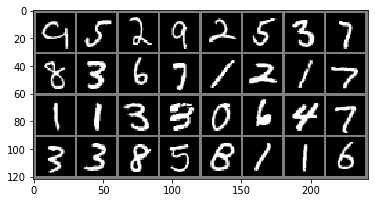

Labels were:
[[9 5 2 9 2 5 3 7]
 [8 3 6 7 1 2 1 7]
 [1 1 3 3 0 6 4 7]
 [3 3 8 5 8 1 1 6]]


In [5]:
def imshow(img, l):
    img = img/2  + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    print('Labels were:')
    print(l.reshape(-1,8).numpy())

# Load sample data
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('shape of images', images.shape)

# display batch
imshow(utils.make_grid(images),labels)

## Loss function for learning.
* NLLLoss: The abbrivation NLL stands for Negetive log likelihood. It is however a bit of misnomer as the log is not included in the loss itself but was part of the network defination above. 
* NOTE: When you want to get the probability/likelihood of an image being of a perticular class you need to remove the log from the forward function and use simple softmax activation at test time. Alternatively simply use ''exp'' function from torch to invert log and leave the forward function as it is. 

## Optimizer
* pytorch have various optimization rutines (beyond SGD) pre-implemented.
* class optim will take care of backpropogation with these different optimizations for learning as long as the network defination with appropriate forward function is written correctly.
* Here we just use SGD. with learning rate 0.001 and momentum 0.9.

In [6]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
if FLAG_GPU:
    criterion = criterion.cuda()

## This cell of the notebook is now training a network.

* First for loop goes throught the entire data 5 times (We run 5 epochs for our training).
* The simple steps for training a NN with pytorch are:
    * Load data in minibatches.
    * Set gradients for all the network parameters to zero (dont forget this)
    * Pass data to the NN using a net.forward() to compute layer by layer output.
        * Intermediate outputs can be returned as extra variables in forward function.
    * Compute the loss from the output (remember it is defined above).
    * Use loss.backword() to compute all the gradients by appropriately applying chain rule! 
        * It actually know how to differentiate things!!!
    * Use optimizer.step() updates weights.
    
## At the end of every epoch usually we check if NN generalizes.
* Generalization is critical in learning.
* We evaluate the performance of our NN on new data, for which the NN loss was not minimized.
* torch.no_grad() command forces the following code to not keep track of the gradients as for testing we dont need them.
* As no gradients are maintained, the code runs faster!
* It a very good practice to make use of no_grad function to ensure that we dont accidently minimize loss on the data we are testing the performance on.


 


In [7]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    
    # Simply for time keeping
    start_time = time.time()
    # Loop over all training data
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
 
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward 
        if FLAG_GPU:
            outputs = net(inputs.cuda())
            loss = criterion(outputs, labels.cuda())
        else:
            outputs = net(inputs)
            loss = criterion(outputs, labels)

        # Compute Gradients
        loss.backward()
        # BackProp
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
        # endif
    # end for over minibatches epoch finishes
    end_time = time.time()

    # test the network every epoch on test example
    correct = 0
    total = 0

    # Test after the epoch finishes (no gradient computation needed)
    with torch.no_grad():
        VIS = True
        for data in testloader:
            # load images and labels
            images, labels = data

            if FLAG_GPU:
                outputs = net(images.cuda())
                # note here we take the max of all probability
                _, predicted = torch.max(outputs.cpu(), 1)
            else:
                outputs = net(images)
                # note here we take the max of all probability
                _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

      #end for
    #end with
    print('Epoch', epoch+1, 'took', end_time-start_time, 'seconds')
    print('Accuracy of the network after', epoch+1, 'epochs is' , 100*correct/total)

print('Finished Training')

[1,   100] loss: 2.223
[1,   200] loss: 1.950
[1,   300] loss: 1.464
[1,   400] loss: 1.051
[1,   500] loss: 0.792
[1,   600] loss: 0.643
[1,   700] loss: 0.546
[1,   800] loss: 0.530
[1,   900] loss: 0.459
[1,  1000] loss: 0.468
[1,  1100] loss: 0.454
[1,  1200] loss: 0.406
[1,  1300] loss: 0.408
[1,  1400] loss: 0.358
[1,  1500] loss: 0.366
[1,  1600] loss: 0.393
[1,  1700] loss: 0.386
[1,  1800] loss: 0.383
Epoch 1 took 14.713677883148193 seconds
Accuracy of the network after 1 epochs is 90.8
[2,   100] loss: 0.345
[2,   200] loss: 0.333
[2,   300] loss: 0.366
[2,   400] loss: 0.320
[2,   500] loss: 0.307
[2,   600] loss: 0.325
[2,   700] loss: 0.317
[2,   800] loss: 0.325
[2,   900] loss: 0.308
[2,  1000] loss: 0.301
[2,  1100] loss: 0.338
[2,  1200] loss: 0.306
[2,  1300] loss: 0.310
[2,  1400] loss: 0.294
[2,  1500] loss: 0.300
[2,  1600] loss: 0.297
[2,  1700] loss: 0.323
[2,  1800] loss: 0.288
Epoch 2 took 13.009875059127808 seconds
Accuracy of the network after 2 epochs is 92.

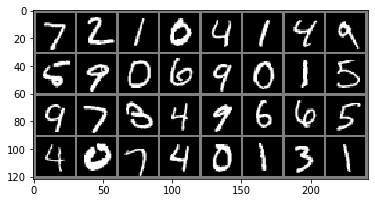

Labels were:
[[7 2 1 0 4 1 4 9]
 [6 9 0 6 9 0 1 5]
 [9 7 3 4 9 6 6 5]
 [4 0 7 4 0 1 3 1]]
Correct labels:
[[7 2 1 0 4 1 4 9]
 [5 9 0 6 9 0 1 5]
 [9 7 3 4 9 6 6 5]
 [4 0 7 4 0 1 3 1]]


In [8]:
iterloader = iter(testloader)
data = next(iterloader)

# load images and labels
images, labels = data

if FLAG_GPU:
    outputs = net(images.cuda())
    # note here we take the max of all probability
    _, predicted = torch.max(outputs.cpu(), 1)
else:
    outputs = net(images)
    # note here we take the max of all probability
    _, predicted = torch.max(outputs, 1)

imshow(utils.make_grid(images),predicted)
print('Correct labels:')
print(labels.reshape(-1,8).numpy())

